In [64]:
import pandas as pd
import re, emoji, urllib, html
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import spacy
nlp = spacy.load("en_core_web_sm") ## load English model and instantiate

## load data

#### subreddit : /r/LanguageTechnology

- `LanguageTechnology.json` : all data that contains records without post text
- `LanguageTechnology_withtext.json` : after dropping records without post text

In [17]:
df = pd.read_json(f'../data/LanguageTechnology.json').drop_duplicates()
df_withtext = pd.read_json(f'../data/LanguageTechnology_withtext.json').drop_duplicates()

df

,vote,title,text,date
0,1,An Emirati girl publishes books to help kids w...,None,2023-10-23
1,8,Do you have a specific hypothesis you would li...,[deleted],2023-07-05
2,1,Empowering Remote Work with Azure Virtual Desktop,None,2023-06-11
3,1,Why Not Ternary Computers? - Laptotech,None,2023-06-11
4,3,"The ""Memory-efficient NLLB-200: Language-speci...",The paper\n promises to release it:\n> We will...,2023-06-10
...,...,...,...,...
5825,1,Interlingual Machine Translation,None,2010-10-07
5826,1,Parts-Of-Speech Tagging,None,2010-03-13
5827,1,Maximum Entropy,None,2010-03-13
5828,1,Tokenization,None,2010-03-10


In [18]:
df_withtext

,vote,title,text,date
0,3,"The ""Memory-efficient NLLB-200: Language-speci...",The paper\n promises to release it:\n> We will...,2023-06-10
1,2,Seeking Suggestions: Enhancing Chat Interactio...,There are numerous plugins available for ChatG...,2023-06-10
2,44,/r/LanguageTechnology will be joining the prot...,On June 12th /r/LanguageTechnology will join t...,2023-06-10
3,49,Introducing SlimPajama-627B: the largest exten...,SlimPajama cleans and deduplicates RedPajama-1...,2023-06-09
4,0,Philosophy blender: Using ChatGPT to create no...,Check out my newest program: Philosophy Blend...,2023-06-09
...,...,...,...,...
3468,1,What are some good resources for doing clause ...,"Books, favorite websites/blogs, etc. I'm goin...",2012-08-06
3469,6,Is it possible to algorithmically rank words b...,"A word is highly ""spellable"" if a high percent...",2012-05-01
3470,3,What is the most accurate method in paraphrase...,I've gone through most of the literature and i...,2011-12-24
3471,1,Handling metaphors,I am working on a project in which i need to d...,2011-11-20


## EDA and Preprocessing : `LanguageTechnology`

#### check null

In [23]:
print(df.isna().sum(), df_withtext.isna().sum(), sep='\n\n')

vote        0
title       0
text     1507
date        0
dtype: int64

vote     0
title    0
text     0
date     0
dtype: int64


#### check length of title and text (character length)

In [36]:
len_df = pd.concat([df['title'].str.len(), df['text'].str.len()], axis=1)
len_df.describe()

,title,text
count,5821.000000,5821.000000
mean,61.147054,409.956365
std,36.656481,805.009663
min,2.000000,0.000000
25%,38.000000,0.000000
50%,54.000000,227.000000
75%,77.000000,567.000000
max,302.000000,24866.000000


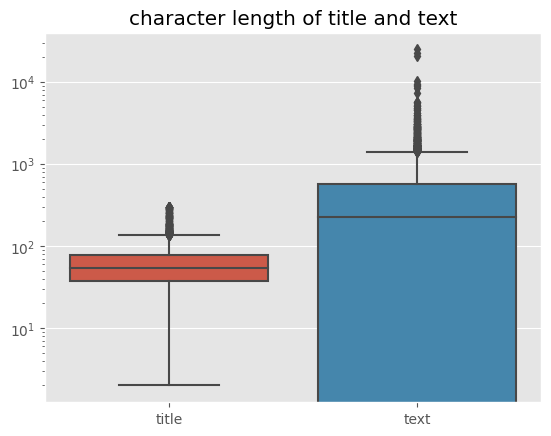

In [42]:
sns.boxplot(data=len_df)
plt.yscale('log')
plt.title('character length of title and text');

#### records with character length less than 20

In [43]:
df[len_df['text'] < 20]['text'].value_counts()

                       1507
[deleted]               500
[removed]               341
what the title says       1
(and why)                 1
Many thanks.              1
Looking for some.         1
Name: text, dtype: int64

#### replace `[deleted]` and `[removed]` with empty string, then combine title and text

In [44]:
df['text'].replace('[removed]', '', inplace=True)
df['text'].replace('[deleted]', '', inplace=True)

df['all_text'] = df['title'] + ' ' + df['text']
df['all_text']

0       An Emirati girl publishes books to help kids w...
1       Do you have a specific hypothesis you would li...
2       Empowering Remote Work with Azure Virtual Desk...
3                 Why Not Ternary Computers? - Laptotech 
4       The "Memory-efficient NLLB-200: Language-speci...
                              ...                        
5825                    Interlingual Machine Translation 
5826                             Parts-Of-Speech Tagging 
5827                                     Maximum Entropy 
5828                                        Tokenization 
5829                   Example based machine translation 
Name: all_text, Length: 5821, dtype: object

#### tokenization with `Spacy`

- remove URLs
- replace `'\n'` with single space `' '`
- remove punctuation
- remove / not remove stopwords

In [93]:
%%time
def tokenize(text, remove_stop=True):
    text = html.unescape(urllib.parse.unquote(text)) # unescape for unicode, unquote for escaped URL
    text = re.sub(r'https?.+?(?:\s|$)', '', text) # remove URL link
    text = re.sub(r'[\n\t \u00a0\xa0\u3000\u2002-\u200a\u202f]+', ' ', text) # shrink whitespaces e.g. good  boy -> good boy
    text = re.sub(r'[\r\u200b\ufeff]+', '', text) # remove non-breaking space

    doc = nlp(text)
    if remove_stop == True:
        return [token.lemma_ for token in doc if token.is_stop == False and token.is_punct == False]
    else:
        return [token.lemma_ for token in doc if token.is_punct == False]

df['token_with_stop'] = df['all_text'].apply(lambda x: tokenize(x, False))
df['token_w/o_stop'] = df['all_text'].apply(lambda x: tokenize(x, True))

CPU times: user 2min 39s, sys: 2.23 s, total: 2min 41s
Wall time: 2min 41s


In [94]:
token_count_with_stop = Counter()
token_count_with_stop.update(sum(df['token_with_stop'], [])) # flattened 1D list of tokens

token_count_without_stop = Counter()
token_count_without_stop.update(sum(df['token_w/o_stop'], [])) # flattened 1D list of tokens


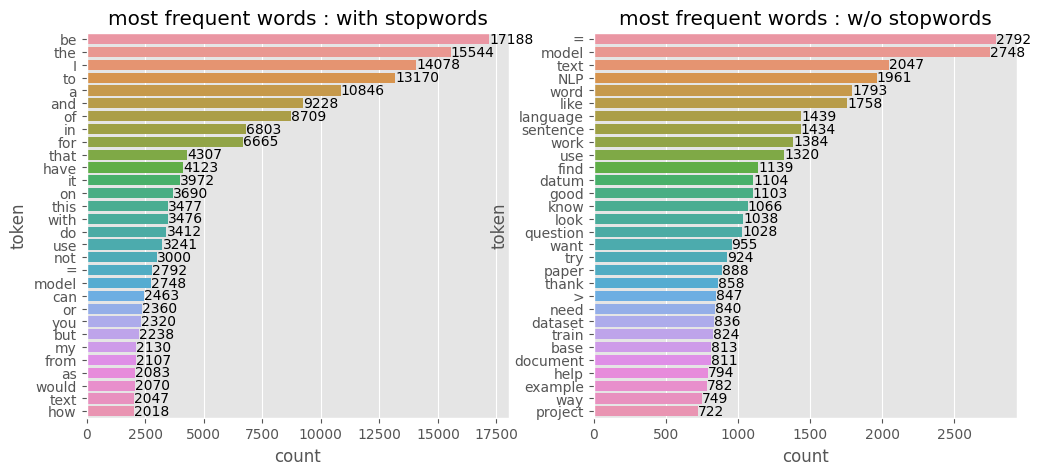

In [95]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
ax = sns.barplot(x='count', y='token', data=pd.DataFrame(token_count_with_stop.most_common(30), columns=['token','count']))
ax.bar_label(ax.containers[0])
plt.title('most frequent words : with stopwords')

plt.subplot(1,2,2)
ax = sns.barplot(x='count', y='token', data=pd.DataFrame(token_count_without_stop.most_common(30), columns=['token','count']))
ax.bar_label(ax.containers[0])
plt.title('most frequent words : w/o stopwords');